# Electrical Energy Output Prediction
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load.

#### Data Exploration

In [4]:
import numpy as np
import torch
import os
from os import path
from sklearn.model_selection import KFold
import pandas as pd
import zipfile
import urllib.request


if not path.exists("UCI"): 
    os.mkdir("UCI")
    
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"
file_name = url.split('/')[-1]
if not path.exists("UCI/" + file_name):
    urllib.request.urlretrieve(url, "UCI/" + file_name)

zipfile.ZipFile("UCI/CCPP.zip").extractall("UCI/CCPP/")
ds = pd.read_excel('UCI/CCPP/Folds5x2_pp.xlsx', header=0)
ds.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


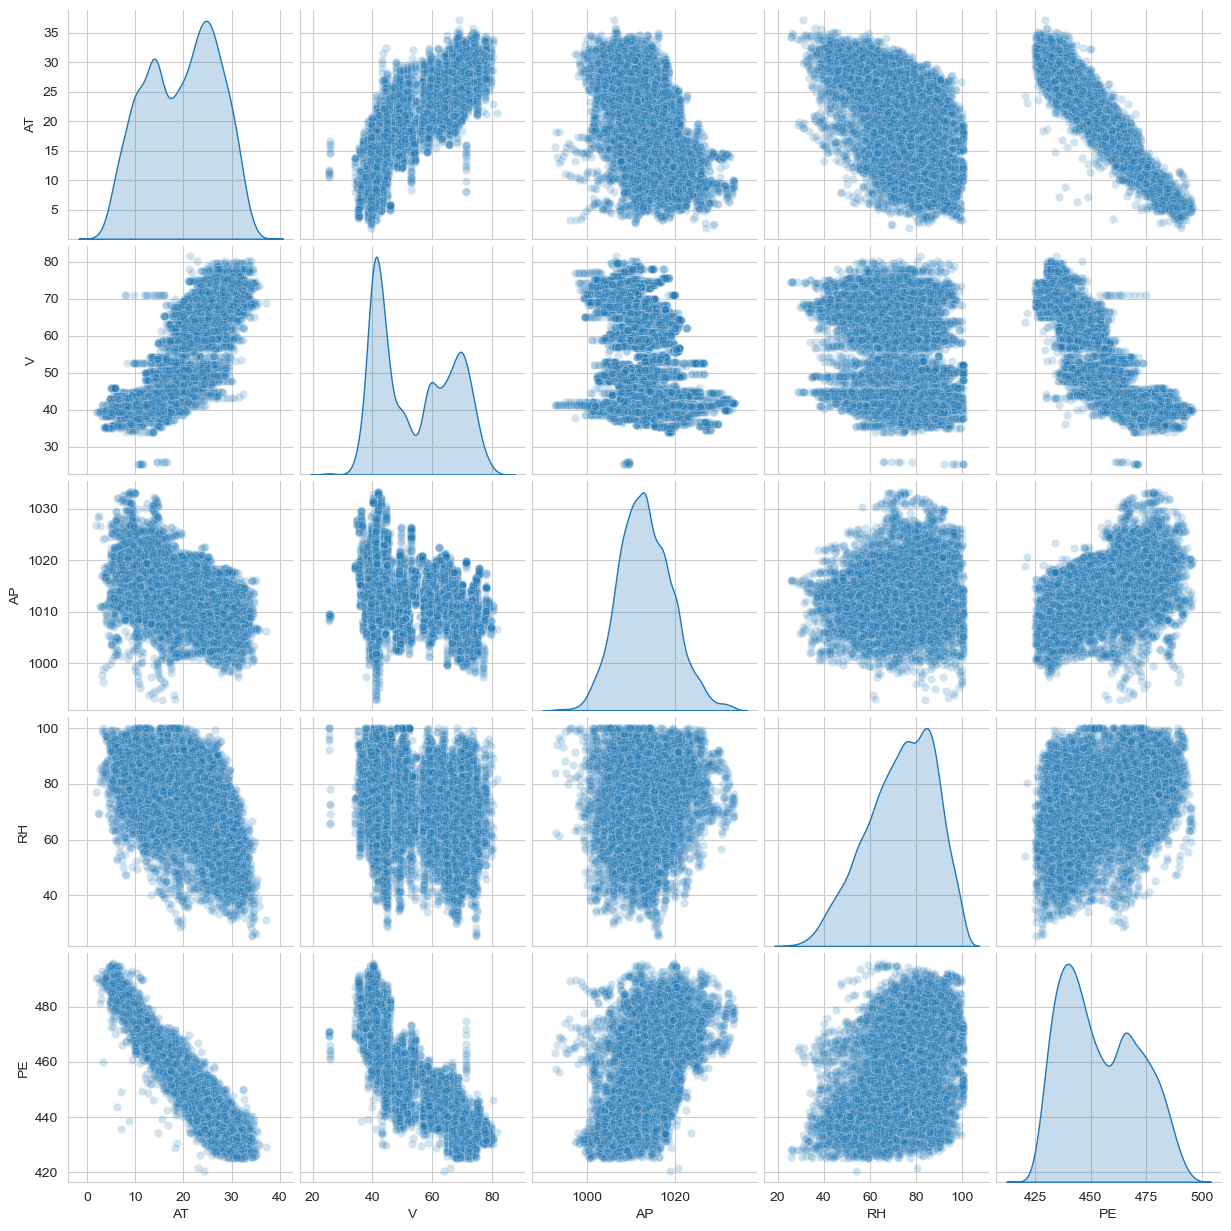

In [5]:
import seaborn as sns

sns.pairplot(ds,diag_kind='kde',plot_kws={'alpha': .2});

In [6]:
# shuffle data
data = ds.values
np.random.shuffle(data)


in_dim, out_dim = data.shape[1] - 1, 1

X, y = data[:, :in_dim], data[:, in_dim:]

# normalize and center data
X_means, X_stds = X.mean(axis=0), X.std(axis=0)
y_means, y_stds = y.mean(axis=0), y.std(axis=0)
X = (X - X_means)/X_stds
y = (y - y_means)/y_stds

#### 5 Fold Cross Validation for Linear Regression

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)
# We use negative mean squared error as score because sklearn expects a score, not a loss
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {-score}')

print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.06758903 0.07028846 0.0749244  0.07323143 0.07096277]
Avg MSE = 0.07


#### 5 Fold Cross Validation for Decision Tree

In [8]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.07076212 0.06845176 0.0733755  0.07013554 0.06120004]
Avg MSE = 0.07


#### 5 Fold Cross Validation for Random Forest

In [9]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.03716461 0.03525024 0.04317639 0.04025023 0.03523409]
Avg MSE = 0.04


#### 5 Fold Cross for Hyper param optimization of Decision Tree

In [10]:
max_depth = [1,5,10,20,50,100]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For max depth: 1
Avg MSE = 0.28
For max depth: 5
Avg MSE = 0.07
For max depth: 10
Avg MSE = 0.06
For max depth: 20
Avg MSE = 0.07
For max depth: 50
Avg MSE = 0.07
For max depth: 100
Avg MSE = 0.07


#### 5 Fold Cross for Hyper param optimization of Random Forest

In [11]:
estimators = [10, 50, 100, 150, 200, 250, 300]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For estimators: 10
Avg MSE = 0.04
For estimators: 50
Avg MSE = 0.04
For estimators: 100
Avg MSE = 0.04
For estimators: 150
Avg MSE = 0.04
For estimators: 200
Avg MSE = 0.04
For estimators: 250
Avg MSE = 0.04
For estimators: 300
Avg MSE = 0.04


#### NN Regressor

In [15]:
from torch import nn

class NNRegressor(nn.Module):
    def __init__(self, layers=[20,30,20], n_features=4, activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.activation_functions = []

        self.layers.append(nn.Linear(n_features, layers[0]))
        self.activation_functions.append(activation())
        self.add_module(f"layer{0}", self.layers[-1])
        self.add_module(f"act{0}", self.activation_functions[-1])

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(self.layers[-1].out_features, layers[i]))
            self.activation_functions.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.activation_functions[-1])

        self.output = nn.Linear(self.layers[-1].out_features, 1)

    def forward(self, x):
        for layer, act in zip(self.layers, self.activation_functions):
            x=act(layer(x))

        x = self.output(x)
        return x

#### Grid search hyper param optimization for NN

In [16]:
from sklearn.model_selection import GridSearchCV
from torch import optim
from skorch import NeuralNetRegressor

param_grid = {
    'optimizer': [optim.Adam, optim.Adamax, optim.NAdam],
    'module__activation': [nn.Identity, nn.ReLU, nn.GELU, nn.Tanh, nn.Sigmoid],
    'batch_size': [10, 25, 50],
    'module__layers': [[10,20,10],[30,20,10],[30,30,30]],
    'lr': [0.0001, 0.001, 0.01],
}

grid = GridSearchCV(
    estimator = NeuralNetRegressor(module=NNRegressor),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 3,
    error_score = 'raise',
    return_train_score = True,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

In [17]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

grid.fit(X_tensor, y_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4260        0.1901  0.2351
      2        0.1646        0.1293  0.2068
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5377        0.1631  0.3170
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9445        0.6512  0.2670
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8287        0.5503  0.3275
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4339        0.1747  0.2939
      3        0.1190        0.0977  0.2648
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5382        0.1640  0.2932
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5463        0.2

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.NNRegressor'>,
),
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50],
                         'lr': [0.0001, 0.001, 0.01],
                         'module__activation': [<class 'torch.nn.modules.linear.Identity'>,
                                                <class 'torch.nn.modules.activation.ReLU'>,
                                                <class 'torch.nn.modules.activation.GELU'>,
                                                <class 'torch.nn.modules.activation.Tanh'>,
                                                <class 'torch.nn.modules.activation.Sigmoid'>],
                         'module__layers': [[10, 20, 10], [30, 20, 10],
                                            [30, 30, 30]],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adamax.Adamax'>,
                                       <class 'torch.optim.nadam.NAdam'>]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [18]:
print("Best params:")
grid.best_params_

Best params:


{'batch_size': 25,
 'lr': 0.001,
 'module__activation': torch.nn.modules.activation.ReLU,
 'module__layers': [30, 30, 30],
 'optimizer': torch.optim.adam.Adam}

In [19]:
print(f'Best MSE = {"{:.2f}".format(-grid.best_score_)}')

Best MSE = 0.06


# Results
The best model is the Random Forest with at least 10 estimators. The avarage MSE for the model is 0.04